## Plan
1. Clean data (if necessary)
2. Put data into a suitable data structure
3. Train models

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [97]:
ruta_raiz = os.path.dirname(os.getcwd()) 
ruta_csv = os.path.join(ruta_raiz, "data", "home-credit-default-risk", "application_train.csv")
data = pd.read_csv(ruta_csv)

In [98]:
print(data.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

The first thing I will do is to create new variables that will better suit the models.

In [99]:
data = data.assign(
    AGE = abs(data['DAYS_BIRTH']) / 365,
    YEARS_EMPLOYED = abs(data['DAYS_EMPLOYED']) / 365,
    INCOME_PER_CHILD = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN'] + 1),
    PAYMENT_RATE = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
)

data["YEARS_EMPLOYED"]

C:\Users\andre\AppData\Local\Temp\ipykernel_10304\3367630293.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data = data.assign(


0            1.745205
1            3.254795
2            0.616438
3            8.326027
4            8.323288
             ...     
307506       0.646575
307507    1000.665753
307508      21.701370
307509      13.112329
307510       3.457534
Name: YEARS_EMPLOYED, Length: 307511, dtype: float64

In [100]:
correlations = data.corr(numeric_only=True)['TARGET'].sort_values()

print("\nFeatures with the highest negative correlation (reduce risk)")
print(correlations.head(15))


print("\nFeautres with the highest positive correlation (increase risk)")
print(correlations.tail(15))


Features with the highest negative correlation (reduce risk)
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
AGE                          -0.078239
YEARS_EMPLOYED               -0.047046
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
Name: TARGET, dtype: float64

Feautres with the highest positive correlation (increase risk)
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CI

In [101]:
def plot_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.histplot(df[column].dropna(), kde=True, color='green')
    plt.title(title)
    plt.show()

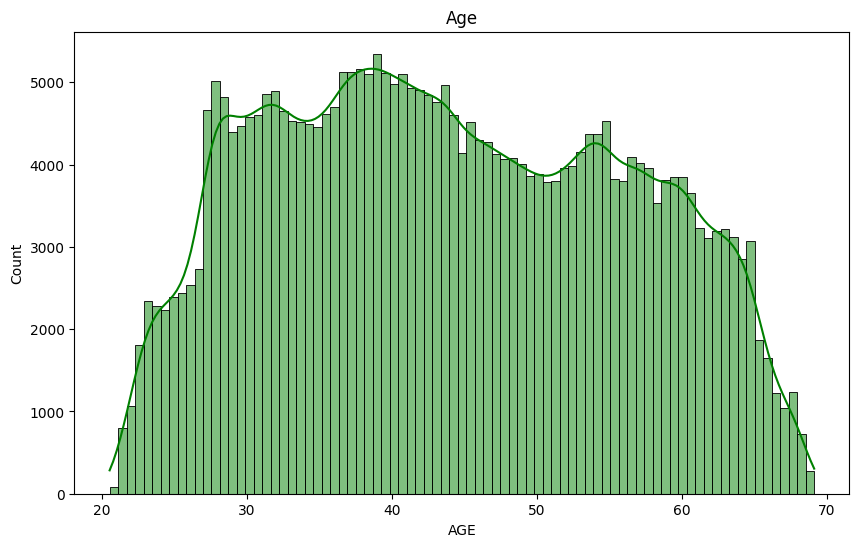

In [102]:
plot_distribution(data, "AGE", "Age")

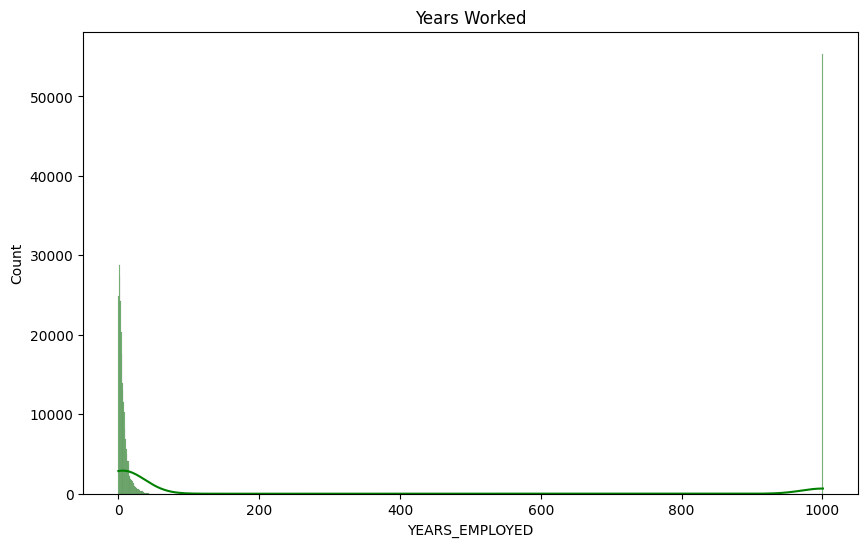

In [103]:
plot_distribution(data, "YEARS_EMPLOYED", "Years Worked")

It looks like the dataset uses the number 365243 as a way to show a borrower is unemployed. I will use this to create a new variable that informs wether a borrower is unemployed.

In [104]:
data["IS_EMPLOYED"] = (data["DAYS_EMPLOYED"] != 365243).astype(int)
data["DAYS_EMPLOYED_CLEAN"] = data["DAYS_EMPLOYED"].replace(365243, 0)
data["YEARS_EMPLOYED_CLEAN"] = abs(data["DAYS_EMPLOYED_CLEAN"]) / 365

C:\Users\andre\AppData\Local\Temp\ipykernel_10304\590873813.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["IS_EMPLOYED"] = (data["DAYS_EMPLOYED"] != 365243).astype(int)
C:\Users\andre\AppData\Local\Temp\ipykernel_10304\590873813.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["DAYS_EMPLOYED_CLEAN"] = data["DAYS_EMPLOYED"].replace(365243, 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_10304\590873813.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

I had a choice to either fill the 365243 with either 0's or with the Median value. The problem with filling it with the median value is those unemployed entries would be interpreted as 4-5 years of experience, which is clearly false.

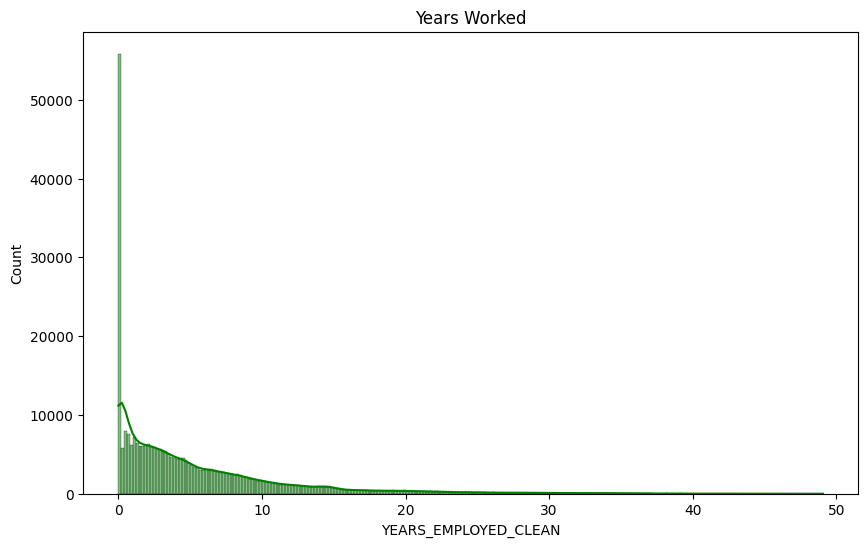

In [105]:
plot_distribution(data, "YEARS_EMPLOYED_CLEAN", "Years Worked")

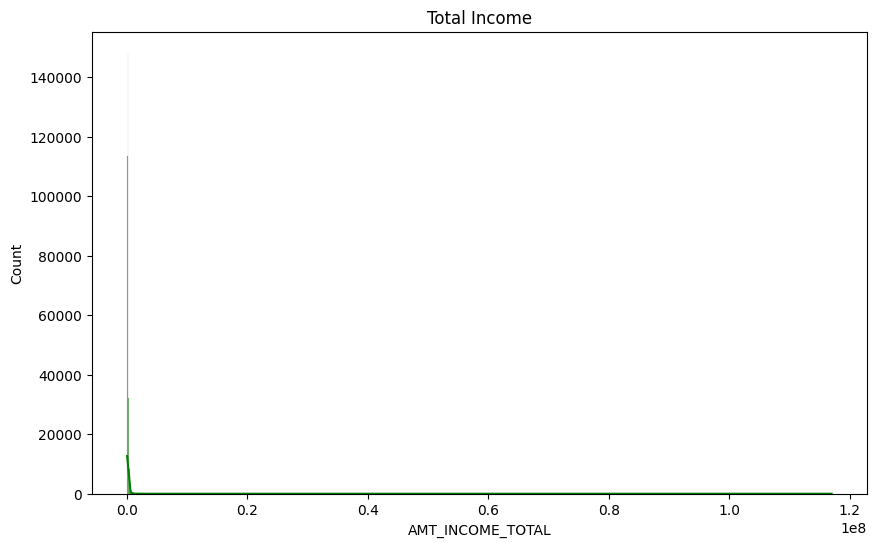

In [106]:
plot_distribution(data, "AMT_INCOME_TOTAL", "Total Income")


To see the Income data properly, I will filter some of the highest income entries that skews the graph.

In [107]:
print(data['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(10))

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
103006      4500000.0
287463      4500000.0
187833      4500000.0
204564      4500000.0
181698      3950059.5
Name: AMT_INCOME_TOTAL, dtype: float64


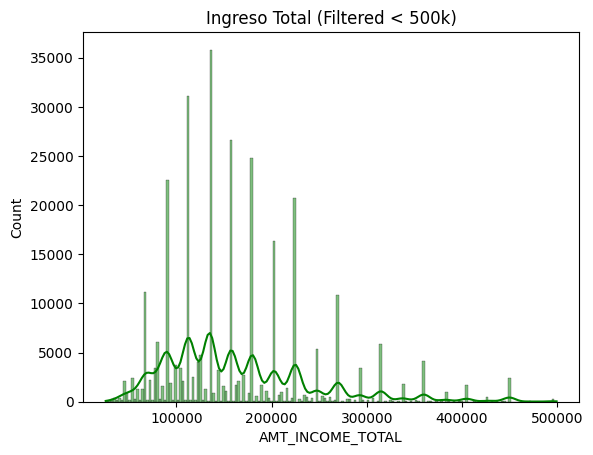

In [108]:
sns.histplot(data[data['AMT_INCOME_TOTAL'] < 500000]['AMT_INCOME_TOTAL'], kde=True, color='green')
plt.title('Ingreso Total (Filtered < 500k)')
plt.show()

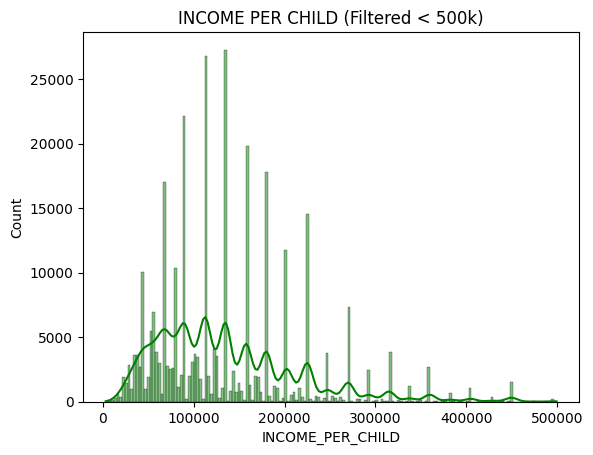

In [109]:
sns.histplot(data[data["AMT_INCOME_TOTAL"] < 500000]["INCOME_PER_CHILD"], kde=True, color='green')
plt.title('INCOME PER CHILD (Filtered < 500k)')
plt.show()

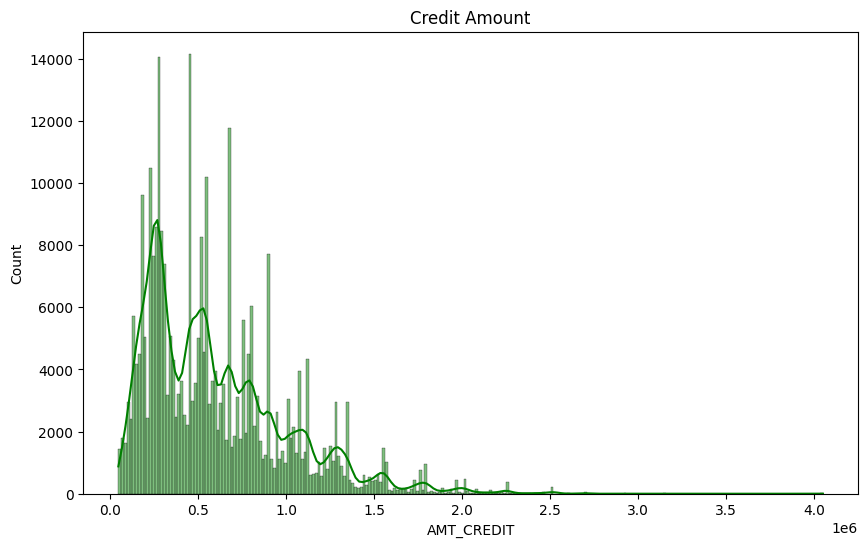

In [110]:
#'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'
plot_distribution(data, "AMT_CREDIT", "Credit Amount")

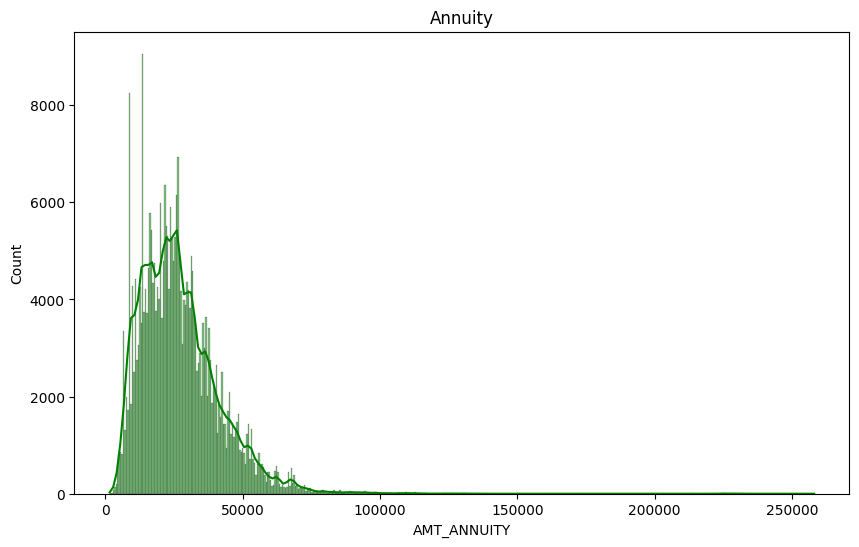

In [111]:
plot_distribution(data, "AMT_ANNUITY", "Annuity")

## Structure Data


In [112]:
cols_to_use = [
    'AMT_CREDIT', 'AMT_ANNUITY', 'AGE', 'YEARS_EMPLOYED_CLEAN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'INCOME_PER_CHILD', 'PAYMENT_RATE', 'REGION_RATING_CLIENT'
]

X = data[cols_to_use]
y = data["TARGET"]

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer

# columns which I decided to fill with the median
cols_to_fill = [
    'AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'INCOME_PER_CHILD', 'AMT_ANNUITY', 'REGION_RATING_CLIENT', 'PAYMENT_RATE'
]

imputer = SimpleImputer(strategy='median')

X_train[cols_to_fill] = imputer.fit_transform(X_train[cols_to_fill])
X_test[cols_to_fill] = imputer.transform(X_test[cols_to_fill])

In [117]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the Model

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(class_weight='balanced', max_iter=1000)


model.fit(X_train_scaled, y_train)

predicciones = model.predict(X_test_scaled)

precision = accuracy_score(y_test, predicciones)

print(precision)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

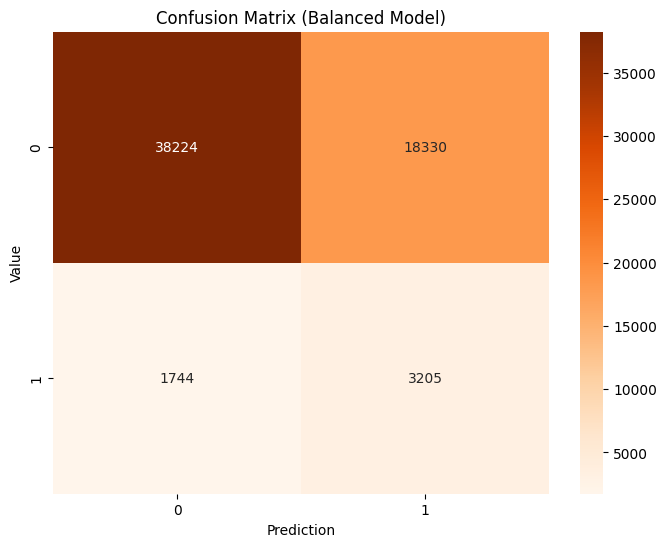

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (Balanced Model)')
plt.ylabel('Value')
plt.xlabel('Prediction')
plt.show()

print(classification_report(y_test, predicciones))